<a href="https://colab.research.google.com/github/vlochub/MIT-Xpro-colab/blob/main/Module20_Video2_and_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Retrieving and preparing the Data



We will work with a dataset that contains the lyrics of almost 90K different songs and its corresponding main genre.

You can find the data in the file `lyric_genre.csv` after downloading it.

Let's inspect it first!


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

keras.utils.set_random_seed(42)

In [ ]:
drive.mount('/content/drive')


# Read data from URL
# Note:
# Create a XPro subfolder in google drive
# In that folder add the three .csv files.

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/XPro/lyric_genre_train.csv', index_col=0).astype(str)
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/XPro/lyric_genre_test.csv', index_col=0).astype(str)
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/XPro/lyric_genre_val.csv', index_col=0).astype(str)

print(f"""
Train samples: {train_df.shape[0]}
Validation samples: {val_df.shape[0]}
Test samples: {test_df.shape[0]}
""")

Mounted at /content/drive

Train samples: 48991
Validation samples: 16331
Test samples: 21774



In [ ]:
train_df.head()

,Lyric,Genre
0,"Oh, girl. I can't get ready (Can't get ready f...",Pop
1,We met on a rainy evening in the summertime. D...,Pop
2,We carried you in our arms. On Independence Da...,Rock
3,I know he loved you. A long time ago. I ain't ...,Pop
4,Paralysis through analysis. Yellow moral uncle...,Rock


In [ ]:
train_df.tail()

,Lyric,Genre
48986,"[Hook]. Beamer, Benz, Or Bentley. Beamer, Benz...",Hip Hop
48987,You never listen to me. I know I'm better off ...,Pop
48988,Things have come to a pretty pass. Our romance...,Pop
48989,"Little baby, on my shoulder. I could fall into...",Pop
48990,Music : Rudolf Schenker. Lyrics: Klaus Meine. ...,Rock


In [ ]:
# Let's check the proportion of each label on training

train_df['Genre'].value_counts() / train_df.shape[0]

,count
Genre,
Rock,0.549448
Pop,0.295136
Hip Hop,0.155416


One thing we need to do before is to convert the `Genre` column into a dummy variable (one-hot encoding). This is because our task will try to predict to which of the 3 categories the song belongs to, and we have to encode this in a way that can be understood by the Neural Network.

In [ ]:
# Let's turn the target into a dummy vector

y_train = pd.get_dummies(train_df['Genre']).to_numpy()
y_val = pd.get_dummies(val_df['Genre']).to_numpy()
y_test = pd.get_dummies(test_df['Genre']).to_numpy()

In [ ]:
y_train

array([[False,  True, False],
       [False,  True, False],
       [False, False,  True],
       ...,
       [False,  True, False],
       [False,  True, False],
       [False, False,  True]])

Let us build now a model that distinguishes the genre from the lyric!

## Baseline Model (Bag of Words)




We will begin by building the simplest model we could come up with:
- We will tokenize at a word level, and each token will be exactly one word (unigram)
- We will use the one-hot encoding that converts each token into a binary vector indicating the presence of the token. Note that when we tokenize at a word level and use a one-hot encoding to indicate the presence (or as we will see later, the count of the word), the model is called **bag of words**.
- `max_tokens` defines the size of the vocabulary the layer is allowed to construct. If the number of tokens in the `adapt` dataset exceeds this number, the layer will choose the `max_tokens` most frequent tokens and ignore the rest.

In [ ]:
# First, we set up our Text Vectorization layer using multi-hot encoding

max_tokens = 5000
text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot")


In [ ]:
# The vocabulary that will be indexed is given by the text corpus on our train dataset
text_vectorization.adapt(train_df['Lyric'])

Let's look at the 20 least common words in our vectorization.

In [ ]:
text_vectorization.get_vocabulary()[-20:]

[np.str_('eden'),
 np.str_('dagger'),
 np.str_('curve'),
 np.str_('cheddar'),
 np.str_('brew'),
 np.str_('appears'),
 np.str_('vacant'),
 np.str_('universal'),
 np.str_('unholy'),
 np.str_('terrified'),
 np.str_('stickin'),
 np.str_('rumble'),
 np.str_('rug'),
 np.str_('pam'),
 np.str_('os'),
 np.str_('ooohh'),
 np.str_('motto'),
 np.str_('marshall'),
 np.str_('loyalty'),
 np.str_('legacy')]

In [ ]:
# We vectorize our input

X_train = text_vectorization(train_df['Lyric'])
X_val = text_vectorization(val_df['Lyric'])
X_test = text_vectorization(test_df['Lyric'])

**Question:**

Each phrase is now a vector. How long is this vector?

<pre>








</pre>

Answer: It is `max_tokens` long i.e., 5000.

In [ ]:
X_train

<tf.Tensor: shape=(48991, 5000), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>

We can think of this matrix as a sequence of row vectors. Each row vector is one of the ~49K songs in our training data, and each entry of this vector indicates the presence of the word that is indexed in that position. For example, the second entry in all the vectors corresponds to the word 'the' and a 1 indicates the presence of that word in the song.

Let's try a simple 1-hidden layer NN with just 8 neurons in the hidden layer.

In [ ]:
inputs = keras.Input(shape=(max_tokens, ))
x = keras.layers.Dense(8, activation="relu")(inputs)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        40,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,035 (156.39 KB)

 Trainable params: 40,035 (156.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Fit model
model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32)

Epoch 1/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7002 - loss: 0.6871 - val_accuracy: 0.7529 - val_loss: 0.5701
Epoch 2/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7728 - loss: 0.5259 - val_accuracy: 0.7497 - val_loss: 0.5778
Epoch 3/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7892 - loss: 0.4886 - val_accuracy: 0.7469 - val_loss: 0.5976
Epoch 4/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8042 - loss: 0.4586 - val_accuracy: 0.7451 - val_loss: 0.6182
Epoch 5/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8173 - loss: 0.4334 - val_accuracy: 0.7427 - val_loss: 0.6466
Epoch 6/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8264 - loss: 0.4118 - val_accuracy: 0.7409 - val_loss: 0.6700
Epoch 7/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8351 - loss: 0.3919 - val_accuracy: 0.7368 - val_loss: 0.7024
Epoch 8/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8439 - loss: 0.3744 -

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7222 - loss: 0.8161


[0.8238804936408997, 0.7207679152488708]

### END Screencast: NLP Coding Walk-Through: Part Two

Note that the largest class is Rock, with around 58%, so a dummy predictor that outputs the most common class would get 58% accuracy.

Our simple 1-hidden layer NN using unigrams and multi-hot encoding improves on that nicely!!


## Word Embeddings




It seems that adding the count of words didn't help us that much.

Crucially, when you encode something via one-hot encoding, you’re making a feature-engineering decision that assummes that the different tokens you’re encoding are all independent from each other: indeed, one-hot vectors are all orthogonal to one another.

In the case of words, that assumption is clearly wrong. Words form a structured space: they share information with each other. The words "movie" and "film" are interchangeable in most sentences, so the vector that represents "movie" should not be orthogonal to the vector that represents "film"—they should be the same vector, or close enough.

Word embeddings are **vector representations** of words that achieve exactly this: they map human language into a structured geometric space.


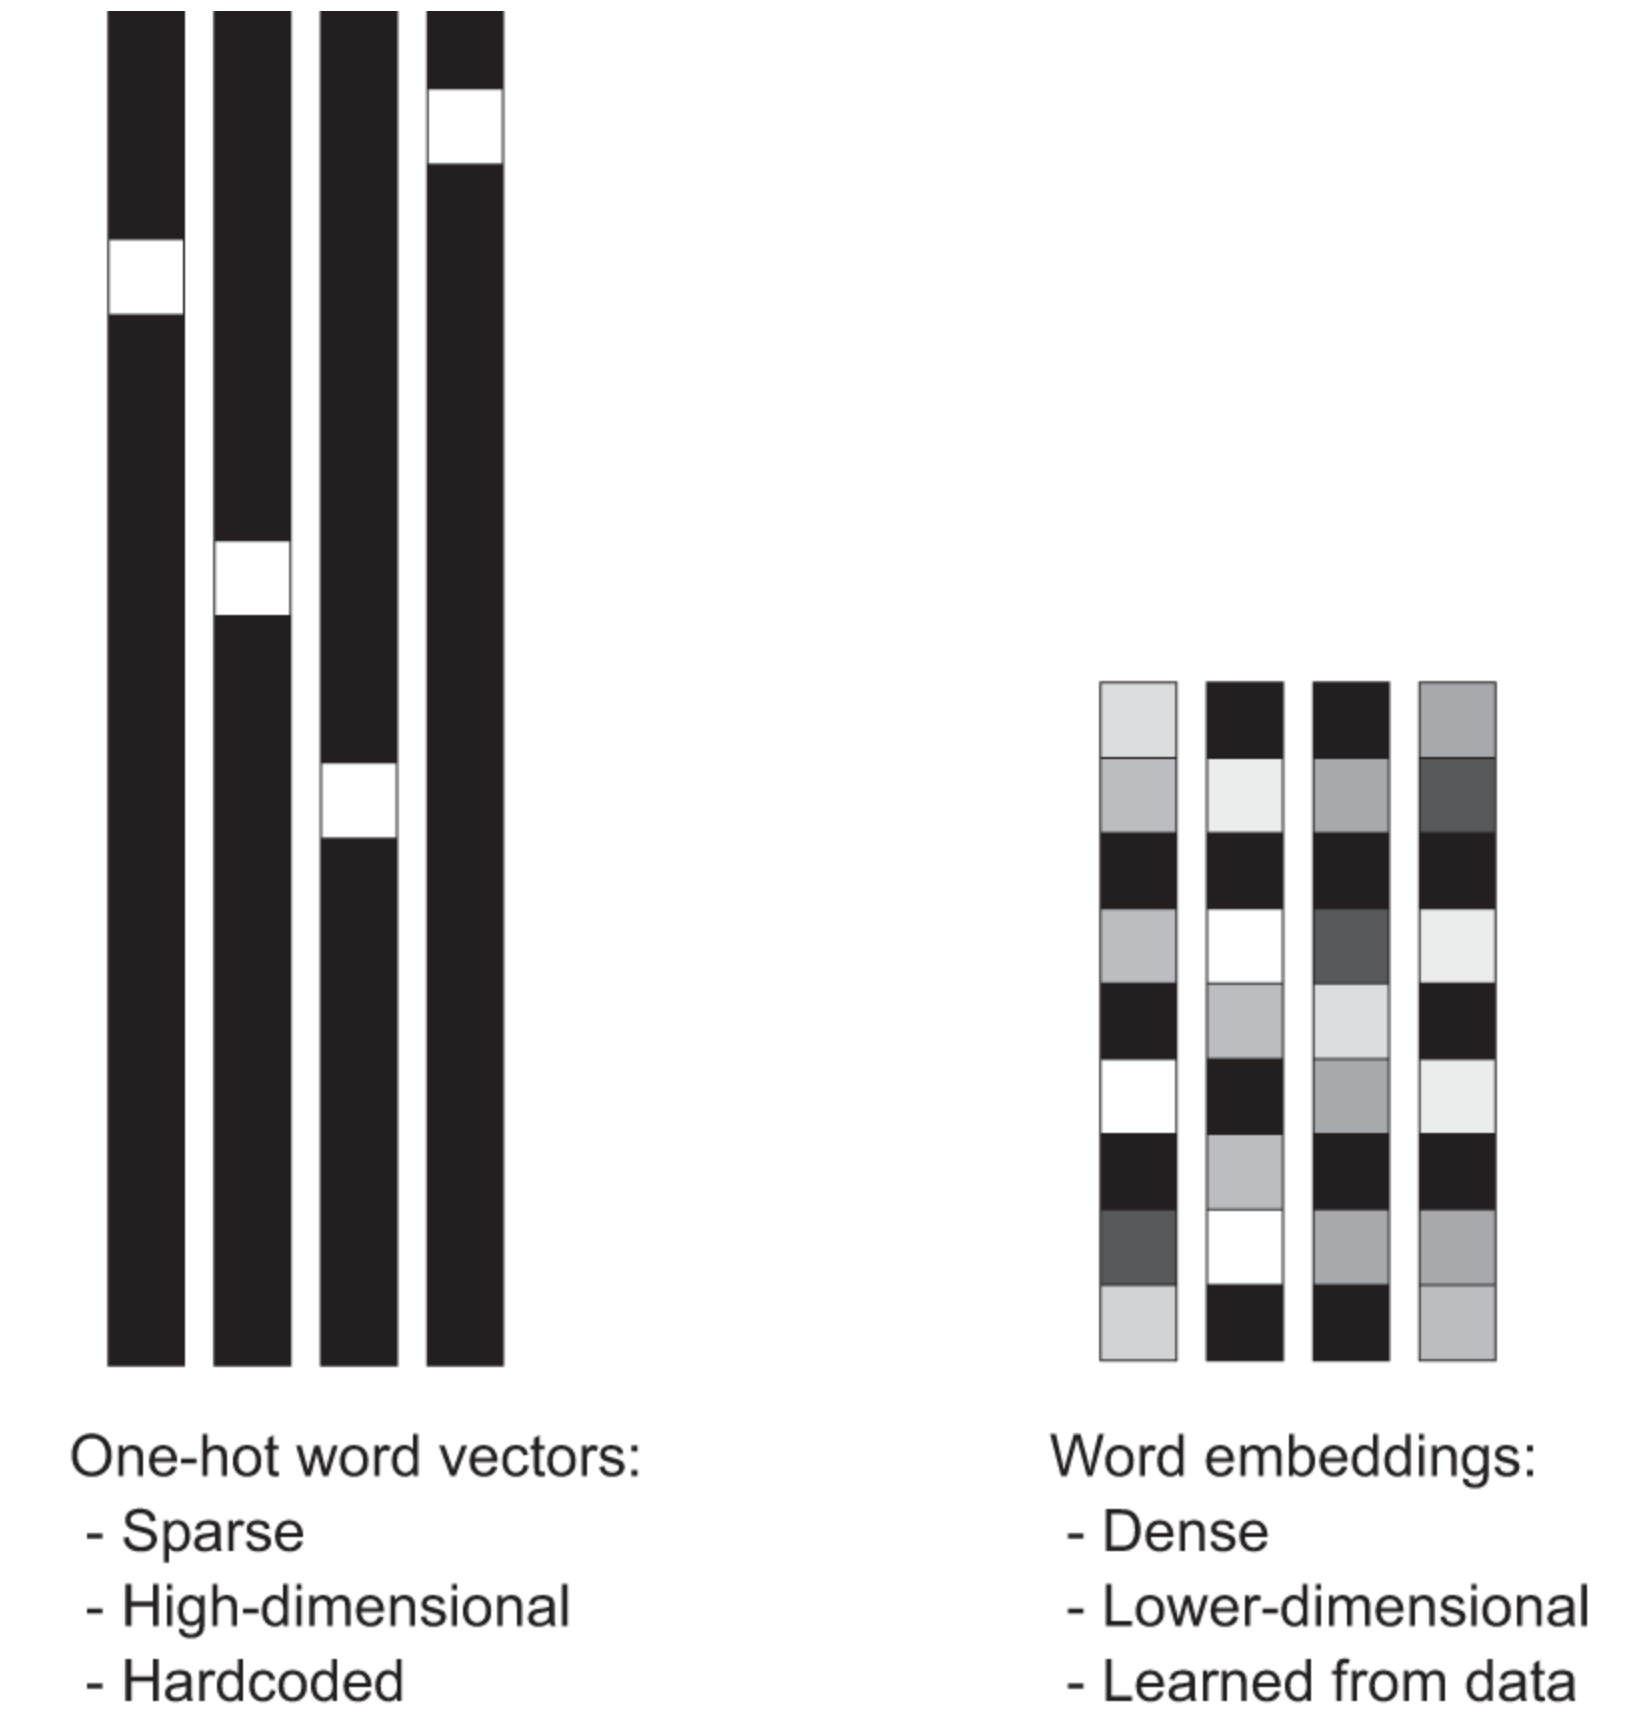

Ideally, word embeddings will try to convey meaning within the geometric space in which the words are represented. For example, a potential representation could have the following structure:

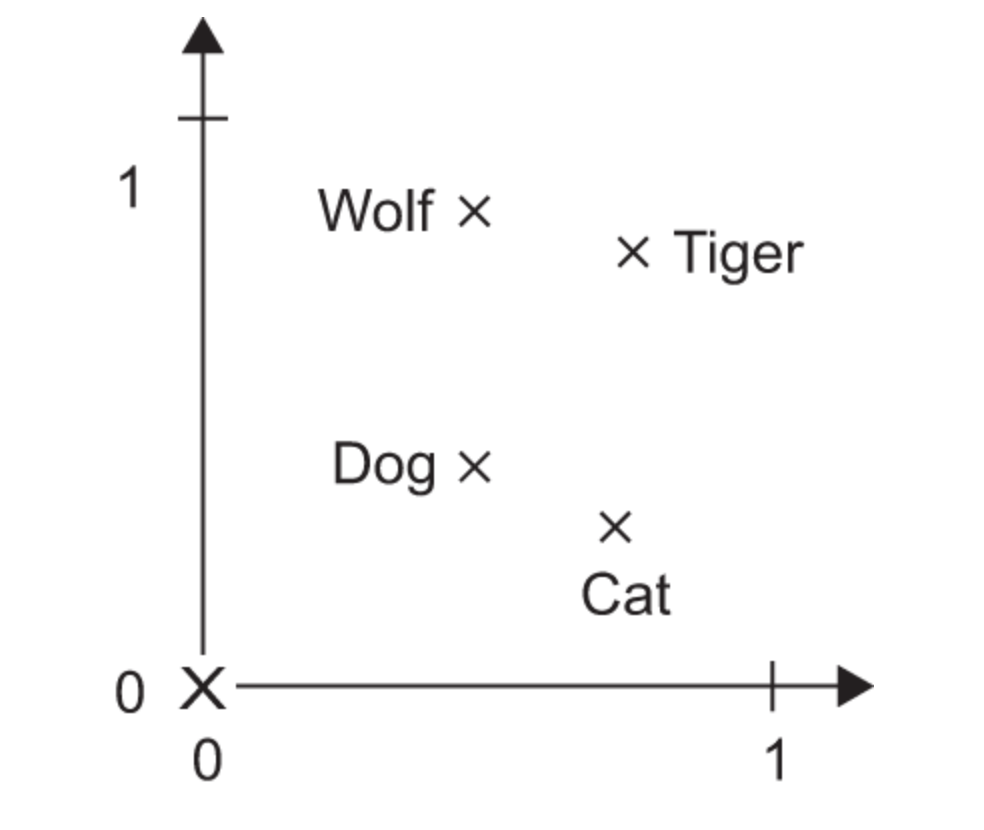

You see the relation between Dog and Wolf with Cat and Tiger? A good embedding should be able to capture these type of semantic meaning.

In real-world word-embedding spaces, common examples of meaningful geometric transformations are "gender" vectors and "plural" vectors. For instance, by adding a "female" vector to the vector "king," we obtain the vector "queen." By adding a "plural" vector, we obtain "kings." Word-embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Where do we get these word embeddings from? We have two options: we can learn them from our data, or insert a previously trained embedding into our model.

Let's now take the second route and use an **already trained word embedding**. This can be useful if you don't have enough data to learn a task-specific embedding of your vocabulary.

It has the drawback that this embedding will not be customized to your data, but they capture generic aspects of language structure. This is not necessarily bad since one would expect that in most cases word features to be fairly generic.

There are a couple of popular word embeddings that you can download and use in a Keras `Embedding` layer (Word2Vec, GloVe).

Let's look at an example using GloVe which was precomputed on the 2014 English Wikipedia dataset.

We first begin by downloading the GloVe word embedding  that contains 100-dimensional embedding vectors of 400,000 words.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-10-15 14:41:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-15 14:41:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-15 14:41:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embedding_dim = 100
path_to_glove_file = f"glove.6B.{embedding_dim}d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Let's take a look at some word vectors.

In [ ]:
embeddings_index["movie"]

array([ 0.38251  ,  0.14821  ,  0.60601  , -0.51533  ,  0.43992  ,
        0.061053 , -0.62716  , -0.025385 ,  0.1643   , -0.22101  ,
        0.14423  , -0.37213  , -0.21683  , -0.08895  ,  0.097904 ,
        0.6561   ,  0.64455  ,  0.47698  ,  0.83849  ,  1.6486   ,
        0.88922  , -0.1181   , -0.012465 , -0.52082  ,  0.77854  ,
        0.48723  , -0.014991 , -0.14127  , -0.34747  , -0.29595  ,
        0.1028   ,  0.57191  , -0.045594 ,  0.026443 ,  0.53816  ,
        0.32257  ,  0.40788  , -0.043599 , -0.146    , -0.48346  ,
        0.32036  ,  0.55086  , -0.76259  ,  0.43269  ,  0.61753  ,
       -0.36503  , -0.60599  , -0.79615  ,  0.3929   , -0.23668  ,
       -0.34719  , -0.61201  ,  0.54747  ,  0.94812  ,  0.20941  ,
       -2.7771   , -0.6022   ,  0.8495   ,  1.2549   ,  0.017893 ,
       -0.041901 ,  2.1147   , -0.026618 , -0.28104  ,  0.68124  ,
       -0.14165  ,  0.99249  ,  0.49879  , -0.67538  ,  0.6417   ,
        0.42303  , -0.27913  ,  0.063403 ,  0.68909  , -0.3618

In [ ]:
embeddings_index["film"]

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

Let's now load the GloVe embeddings into the model and train it!

In [ ]:
max_length = 300 #90% of songs
max_tokens = 5000

text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

We haven't seen the `output_sequence_length` argument before. This basically truncates any doc to the length specified by the argument. If the document is shorter it is padded with the empty tokens (i.e. tokens that index to 0)

In [ ]:
text_vectorization.adapt(train_df['Lyric'])

In [ ]:
X_train = text_vectorization(train_df['Lyric'])
X_val = text_vectorization(val_df['Lyric'])
X_test = text_vectorization(test_df['Lyric'])

In [ ]:
X_train

<tf.Tensor: shape=(48991, 300), dtype=int64, numpy=
array([[  40,   83,    4, ...,   22,  729,    3],
       [  20,  649,   13, ...,    0,    0,    0],
       [  20, 2872,    3, ...,    0,    0,    0],
       ...,
       [ 153,   66,   62, ...,    0,    0,    0],
       [ 119,   51,   13, ...,    0,    0,    0],
       [ 358,    1,    1, ...,    0,    0,    0]])>

To add a word embedding to our model, we can use a Keras layer called `Embedding` and incorporate it as an extra layer of our Neural Network.

The Embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. It takes integers as input, looks up these integers in an internal dictionary, and returns the associated vectors. It’s effectively a dictionary lookup.

The Embedding layer takes as input a rank-2 tensor of integers, of shape (batch_size, sequence_length), where each entry is a sequence of integers. The layer then returns a 3D floating-point tensor of shape (batch_size, sequence_length, embedding_ dimensionality).

When you instantiate an Embedding layer, its weights (its internal dictionary of token vectors) are initially random, just as with any other layer. During training, these word vectors are gradually adjusted via gradient descent (i.e., backpropagation).

Since we want to use the downloaded GLoVE embeddings, we will first build a matrix of shape `(max_words, embedding_dim)` and fix it as the embeddings of the `Embedding` layer.

We will add an extra argument `trainable=False` to freeze the layer to avoid disrupting these pretrained GLoVE embeddings during training.

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

counter = 0
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        counter += 1


The above code creates a lookup table that maps integers to the corresponding word vectors

In [ ]:
embedding_matrix.shape

(5000, 100)

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

counter = 0
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            counter += 1

We can now feed this matrix as the initial weights of the `Embedding` layer.


The first argument of the method corresponds to the number of possible tokens, and the second is the dimension of the geometrical space where we will represent our words.

In [ ]:
embedding_layer = keras.layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer= keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
print(f'There are {counter} words on our vocabulary not present in the Glove embedding')
print(f'This is roughly {counter / max_tokens * 100:.2f}% of the vocabulary')
print('These words will be represented by a vector of 0 in all entries in the embedding')

There are 155 words on our vocabulary not present in the Glove embedding
This is roughly 3.10% of the vocabulary
These words will be represented by a vector of 0 in all entries in the embedding


We can now build a Neural Network with an embedding layer after its input layer. This layer will use the already computed Glove embeddings to convert each word in the document into a dense vector. Thus, each text will be represented by a matrix.

How do we convert this matrix in something that can be used as a vector that can be fed to the next Dense layer of the network? There are actually many answers to this, but the approach we will take will be to take the average of the vectors of each word in the text, and that will be the representation of the review in the embedded space. We  use the `GlobalAveragePooling1D` layer ([link](https://keras.io/api/layers/pooling_layers/global_average_pooling1d/)) layer for this purpose.

**SWITCH TO IPAD TO EXPLAIN VISUALLY HOW THIS WORKS**






In [ ]:
inputs = keras.Input(shape=(max_length,))
embedded = embedding_layer(inputs) # 300 x 100 table comes out
embedded = keras.layers.GlobalAveragePooling1D()(embedded) # 100-element vector
x = keras.layers.Dense(8)(embedded)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,835 (1.91 MB)

 Trainable params: 835 (3.26 KB)

 Non-trainable params: 500,000 (1.91 MB)

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Fit model
model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32,)

Epoch 1/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5559 - loss: 0.9639 - val_accuracy: 0.6383 - val_loss: 0.7993
Epoch 2/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6270 - loss: 0.8224 - val_accuracy: 0.6635 - val_loss: 0.7670
Epoch 3/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6419 - loss: 0.7992 - val_accuracy: 0.6611 - val_loss: 0.7588
Epoch 4/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6503 - loss: 0.7932 - val_accuracy: 0.6679 - val_loss: 0.7507
Epoch 5/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6535 - loss: 0.7879 - val_accuracy: 0.6607 - val_loss: 0.7549
Epoch 6/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6554 - loss: 0.7874 - val_accuracy: 0.6682 - val_loss: 0.7501
Epoch 7/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6529 - loss: 0.7830 - val_accuracy: 0.6652 - val_loss: 0.7509
Epoch 8/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6570 - loss: 0.7817

You’ll find that on this particular task, pretrained embeddings aren’t very helpful, because the dataset contains enough samples that it is possible to learn a pretty enough specialized embedding space from scratch. However, leveraging pretrained embeddings can be very helpful when you’re working with a smaller dataset.

Remember how we had set the `trainable` parameter to `False` when setting the embedding layer? What would happen if we change this?

One can think in the Embedding layer as taking the vectorized representation of words and adding weights to each component to form a new vector in a lower dimensional space. These weights are fixed and come from the Glove embedding. But since the Embedding layer is just another layer in our Neural Network, we could update those weights with gradient descent.

Let's try that out!


In [ ]:
embedding_layer = keras.layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

inputs = keras.Input(shape=(max_length,))
embedded = embedding_layer(inputs)
embedded = keras.layers.GlobalAveragePooling1D()(embedded)
x = keras.layers.Dense(8)(embedded)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 300, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,835 (1.91 MB)

 Trainable params: 500,835 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
# Fit model
model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32,)

Epoch 1/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.6337 - loss: 0.8296 - val_accuracy: 0.7169 - val_loss: 0.6522
Epoch 2/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7139 - loss: 0.6832 - val_accuracy: 0.7255 - val_loss: 0.6287
Epoch 3/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.7248 - loss: 0.6503 - val_accuracy: 0.7304 - val_loss: 0.6209
Epoch 4/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7324 - loss: 0.6290 - val_accuracy: 0.7350 - val_loss: 0.6184
Epoch 5/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7387 - loss: 0.6191 - val_accuracy: 0.7311 - val_loss: 0.6177
Epoch 6/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7408 - loss: 0.6084 - val_accuracy: 0.7318 - val_loss: 0.6261
Epoch 7/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7498 - loss: 0.5972 - val_accuracy: 0.7308 - val_loss: 0.6276
Epoch 8/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7514 -

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7304 - loss: 0.6388


[0.6421234011650085, 0.7302746176719666]

Nice improvement!

Let's run the model on a lyric fragment and see what it predicts. We will create a little helper function to make life easier.

In [ ]:
def lyric_predict(phrase):
    raw_text_data = tf.convert_to_tensor([[phrase],])

    vect_data = text_vectorization(raw_text_data)
    predictions = model.predict(vect_data)
    predictions
    print(f"{float(predictions[0,0] * 100):.2f} % Hip-Hop")
    print(f"{float(predictions[0,1] * 100):.2f} % Pop")
    print(f"{float(predictions[0,2] * 100):.2f} % Rock")

In [ ]:
phrase = '''I grew up on the crime side, the New York Times side
Stayin' alive was no jive
Had secondhands, Mom's bounced on old man
So then we moved to Shaolin land
A young youth, yo, rockin' the gold tooth, 'Lo goose
Only way I begin the G off was drug loot
And let's start it like this, son
Rollin' with this one and that one, pullin' out gats for fun
But it was just a dream for the teen
Who was a fiend, started smokin' woolies at 16
And runnin' up in gates and doin' hits for high stakes
Makin' my way on fire escapes
No question, I would speed for cracks and weed
The combination made my eyes bleed
No question, I would flow off and try to get the dough all
Stickin' up white boys in ball courts
My life got no better, same damn 'Lo sweater
Times is rough and tough like leather
Figured out I went the wrong route
So I got with a sick-ass clique and went all out
Catchin' keys from 'cross seas
Rollin' in MPV's, every week we made forty G's
Yo, ****, respect mine, or here go the TEC-9
Ch-chick-pow! Move from the gate now'''

lyric_predict(phrase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
53.59 % Hip-Hop
17.21 % Pop
29.20 % Rock


In [ ]:
phrase = '''I walked through the door with you
The air was cold
But something about it felt like home somehow
And I, left my scarf there at your sister's house
And you've still got it in your drawer even now
Oh, your sweet disposition
And my wide-eyed gaze
We're singing in the car, getting lost upstate
Autumn leaves falling down like pieces into place
And I can picture it after all these days
And I know it's long gone and that magic's not here no more
And I might be okay but I'm not fine at all
'Cause there we are again on that little town street
You almost ran the red 'cause you were lookin' over at me
Wind in my hair, I was there
I remember it all too well
Photo album on the counter
Your cheeks were turning red
You used to be a little kid with glasses in a twin-sized bed
And your mother's telling stories 'bout you on the tee-ball team
You told me 'bout your past thinking your future was me
And I know it's long gone and there was nothing else I could do
And I forget about you long enough to forget why I needed to
'Cause there we are again in the middle of the night
We're dancing 'round the kitchen in the refrigerator light
Down the stairs, I was there
I remember it all too well, yeah
And maybe we got lost in translation
Maybe I asked for too much
But maybe this thing was a masterpiece 'til you tore it all up
Running scared, I was there
I remember it all too well
And you call me up again just to break me like a promise
So casually cruel in the name of being honest
I'm a crumpled up piece of paper lying here
'Cause I remember it all, all, all
Too well'''

lyric_predict(phrase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6.19 % Hip-Hop
42.08 % Pop
51.72 % Rock


## Adding Context with Bigrams



We're basically at 73% accuracy at this point!

Can we do any better? Is there any aspect of the text that we're failing to capture with all the models we've seen so far?

Suppose we're trying to predict the sentiment of a movie review that looks something like this:

"Kate Winslet's performance as a detective trying to solve a terrible crime in a small Pennsylvania town is anything but dissapointing."

How would this be interpreted by our models that look at each word *separately*? Notice the words "terrible" and "dissapointing". These are words that carry a negative sentiment if looked out of context. However, by looking at the words sorrounding them ("terrible crime", "anything but dissapointing"), one can immediately notice that the first one is not a description of the quality of the movie, and the second one is actually a positive review.

Although is easy for us to realize this, how can we make our models more context aware? As the example above suggests, we can look at words as groups instead of single entities. One way to do this is to change the way we do the Tokenization, and instead of picking words one by one, we can also pick pairs or more consecutive words.

Let's start using bigrams, which will use pair of *consecutive* words as the level of tokenization to add more context to our models.

The reason why we would like to do this is that discarding word order is very reductive, and because even atomic concepts can be expressed via multiple words: the term "United States" conveys a concept that is quite distinct from the meaning of the words "states" and "united" taken separately. For this reason, you will usually end up re-injecting local order information into your bag-of-words representation by looking at N-grams rather than single words (most commonly, bigrams).



In [ ]:
# Text Vectorization layer using bigrams
text_vectorization = keras.layers.TextVectorization(
    ngrams=2,
    output_mode="multi_hot")

In [ ]:
text_vectorization.adapt(["the cat sat on a mat."])

In [ ]:
text_vectorization.get_vocabulary()

['[UNK]',
 np.str_('the cat'),
 np.str_('the'),
 np.str_('sat on'),
 np.str_('sat'),
 np.str_('on a'),
 np.str_('on'),
 np.str_('mat'),
 np.str_('cat sat'),
 np.str_('cat'),
 np.str_('a mat'),
 np.str_('a')]